In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import torch
import matplotlib.pyplot as plt
from denoising.networks import RED_CNN
from collections import OrderedDict


def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

base_denoising_model  = load_model('../denoising/models/redcnn')
aug_denoising_model = load_model('../denoising/models/redcnn_augmented')

In [2]:
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

In [3]:
test_input = np.load('../data/Denoising_Data/test_input.npy').squeeze()
test_target = np.load('../data/Denoising_Data/test_target.npy').squeeze()

nexample = 2
base_CNNout = base_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()
aug_CNNout = aug_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


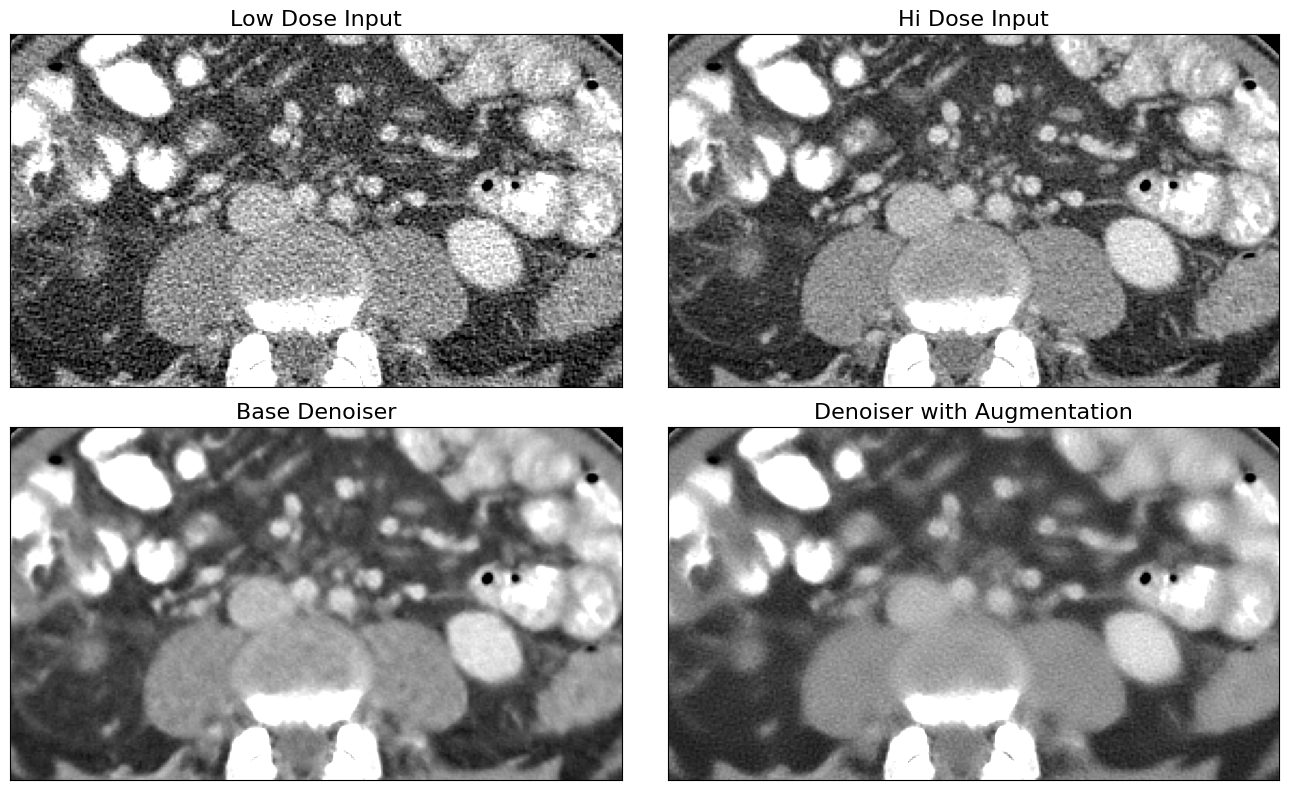

In [4]:
plt.figure(figsize=(16, 8), tight_layout=True)

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50])

plt.subplot(2, 2, 3)
plt.title('Base Denoiser', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50])

plt.subplot(2, 2, 4)
plt.title('Denoiser with Augmentation', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50])
plt.savefig(f'test_patient.png', dpi=600, bbox_inches='tight')

In [130]:
import pandas as pd
from pathlib import Path
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/anthropomorphic/')
df = pd.read_csv(base_dir / 'metadata.csv')
df

,Code #,Name,age (year),gender,weight (kg),height (cm),BMI,weight percentile,ethnicity,effective diameter (cm),Dose [%],recon,file
0,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...
1,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,RED-CNN,male_infant_ref/diameter111mm/dose_010/RED-CNN...
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,fbp,male_infant_ref/diameter111mm/dose_010/fbp/mal...
3,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,40,RED-CNN augmented,male_infant_ref/diameter111mm/dose_040/RED-CNN...
4,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,40,RED-CNN,male_infant_ref/diameter111mm/dose_040/RED-CNN...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,70,RED-CNN,female_pt151/diameter281mm/dose_070/RED-CNN/fe...
416,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,70,fbp,female_pt151/diameter281mm/dose_070/fbp/female...
417,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,85,RED-CNN augmented,female_pt151/diameter281mm/dose_085/RED-CNN au...
418,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,85,RED-CNN,female_pt151/diameter281mm/dose_085/RED-CNN/fe...


Code #                                                     Reference newborn
Name                                                             male infant
age (year)                                                             0.166
gender                                                                     M
weight (kg)                                                              3.8
height (cm)                                                             52.0
BMI                                                                     14.1
weight percentile                                                       36.0
ethnicity                                                                NaN
effective diameter (cm)                                                 11.1
Dose [%]                                                                  10
recon                                                      RED-CNN augmented
file                       male_infant_ref/diameter111mm/dose_010/RED-CNN...

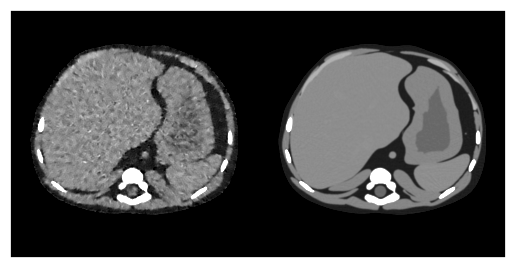

In [151]:
import SimpleITK as sitk

def load_img(mhd): return sitk.GetArrayFromImage(sitk.ReadImage(mhd))
def get_ground_truth(fname): return Path(fname).parents[2] / 'noise_free.mhd'

patient = df.iloc[0]
offset = 1000 if patient.recon == 'fbp' else 0
img = load_img(base_dir / patient.file) - offset
gt = load_img(base_dir / get_ground_truth(patient.file)) - 1000
print(patient)
ctshow(np.concatenate([img[1], gt], axis=1))

In [173]:
df

,Code #,Name,age (year),gender,weight (kg),height (cm),BMI,weight percentile,ethnicity,effective diameter (cm),Dose [%],recon,file,sim number,rmse
0,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,NaN,NaN
1,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,RED-CNN,male_infant_ref/diameter111mm/dose_010/RED-CNN...,NaN,NaN
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,10,fbp,male_infant_ref/diameter111mm/dose_010/fbp/mal...,NaN,NaN
3,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,40,RED-CNN augmented,male_infant_ref/diameter111mm/dose_040/RED-CNN...,NaN,NaN
4,Reference newborn,male infant,0.166,M,3.8,52.0,14.100000,36.0,NaN,11.1,40,RED-CNN,male_infant_ref/diameter111mm/dose_040/RED-CNN...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,70,RED-CNN,female_pt151/diameter281mm/dose_070/RED-CNN/fe...,NaN,NaN
416,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,70,fbp,female_pt151/diameter281mm/dose_070/fbp/female...,NaN,NaN
417,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,85,RED-CNN augmented,female_pt151/diameter281mm/dose_085/RED-CNN au...,NaN,NaN
418,151,female pt151,66.000,F,66.4,162.0,25.301021,48.8,white,28.1,85,RED-CNN,female_pt151/diameter281mm/dose_085/RED-CNN/fe...,NaN,NaN


In [174]:
patient

(0,
 Code #                                                     Reference newborn
 Name                                                             male infant
 age (year)                                                             0.166
 gender                                                                     M
 weight (kg)                                                              3.8
 height (cm)                                                             52.0
 BMI                                                                     14.1
 weight percentile                                                       36.0
 ethnicity                                                                NaN
 effective diameter (cm)                                                 11.1
 Dose [%]                                                                  10
 recon                                                      RED-CNN augmented
 file                       male_infant_ref/diameter111mm/do

```python
# this belongs in the `apply_denoisers.py`
meta = df.columns[:9]
patient_info = df[meta]
patient_info = patient_info[patient_info.duplicated() == False].sort_values('age (year)').reset_index(drop=True)
patient_info

def get_patient_filename(name):
    name = name.replace(' ', '_')
    if name.endswith('yr') or name.endswith('infant'): name+='_ref'
    return name

rows_list = []
for idx, patient in patient_info.iterrows():
    studies = [o for o in (base_dir / get_patient_filename(patient.Name)).rglob('*.mhd') if o.stem not in ['noise_free', 'true']]
    for study in studies:
        patient_code, diameter, dose, recon, fname = study.relative_to(base_dir).parts
        patient['effective diameter (cm)'] = float(diameter.split('diameter')[1].split('mm')[0])/10
        patient['Dose [%]'] = int(dose.split('dose_')[1])
        patient['recon'] = recon
        patient['file'] = str(study.relative_to(base_dir))
        rows_list.append(pd.DataFrame(patient).T)
results = pd.concat(rows_list, ignore_index=True)
results.to_csv(base_dir / 'metadata.csv', index=False)
```

In [185]:
# this cell is similar to above, it should be in the code and imported into notebooks
df['sim number'] = np.nan
df['rmse'] = np.nan

rows_list = []
for idx, patient in df.iterrows():
    offset = 1000 if patient.recon == 'fbp' else 0
    img = load_img(base_dir / patient.file) - offset
    gt = load_img(base_dir / get_ground_truth(patient.file)) - 1000

    if img.ndim == 2: img = img[None, ...]
    nsims = img.shape[0]
    for n, o in enumerate(img):
        patient['sim number'] = n
        patient['rmse'] = rmse(o, gt)
        rows_list.append(pd.DataFrame(patient).T)
results = pd.concat(rows_list, ignore_index=True)
results['phantom'] = 'anthropomorphic'
# results.pop('file')
results

,Code #,Name,age (year),gender,weight (kg),height (cm),BMI,weight percentile,ethnicity,effective diameter (cm),Dose [%],recon,file,sim number,rmse,phantom
0,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,0,21.928907,anthropomorphic
1,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,1,22.138371,anthropomorphic
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,2,22.002787,anthropomorphic
3,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,3,21.875196,anthropomorphic
4,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,4,21.453865,anthropomorphic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,151,female pt151,66.0,F,66.4,162.0,25.301021,48.8,white,28.1,85,fbp,female_pt151/diameter281mm/dose_085/fbp/female...,5,20.10227,anthropomorphic
4196,151,female pt151,66.0,F,66.4,162.0,25.301021,48.8,white,28.1,85,fbp,female_pt151/diameter281mm/dose_085/fbp/female...,6,20.050429,anthropomorphic
4197,151,female pt151,66.0,F,66.4,162.0,25.301021,48.8,white,28.1,85,fbp,female_pt151/diameter281mm/dose_085/fbp/female...,7,20.017807,anthropomorphic
4198,151,female pt151,66.0,F,66.4,162.0,25.301021,48.8,white,28.1,85,fbp,female_pt151/diameter281mm/dose_085/fbp/female...,8,20.171213,anthropomorphic


In [186]:
results.to_csv('results.csv', index=False)

In [187]:
df['is adult'] = df['age (year)'] >= 22

<Axes: xlabel='age (year)', ylabel='weight (kg)'>

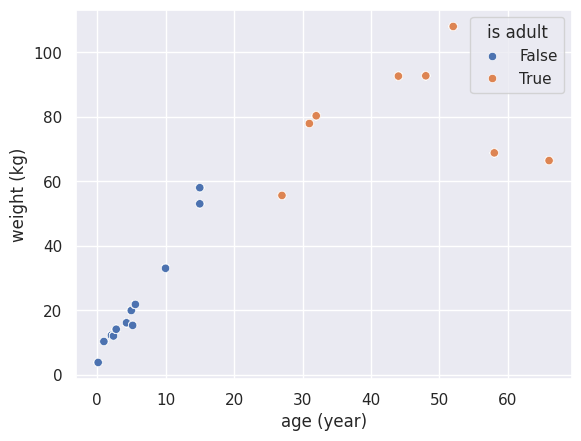

In [188]:
import seaborn as sns
sns.scatterplot(data=df, x='age (year)', y='weight (kg)', hue='is adult')

<Axes: xlabel='age (year)', ylabel='effective diameter (cm)'>

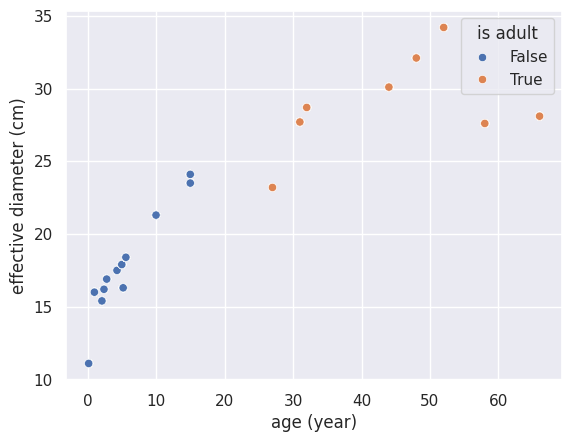

In [189]:
sns.scatterplot(data=df, x='age (year)', y='effective diameter (cm)', hue='is adult')

In [190]:
len(df[df['is adult']==True].Name.unique()), len(df[df['is adult']==False].Name.unique())

(8, 12)

In [193]:
recon_order = order_recons(results.recon.unique())

<Axes: xlabel='effective diameter (cm)', ylabel='rmse'>

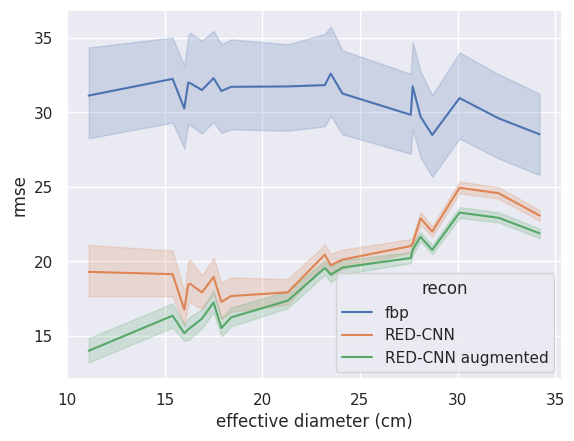

In [194]:
sns.lineplot(data=results, x='effective diameter (cm)', y='rmse', hue='recon', hue_order=recon_order)

^^ Check out some representative values and images to see that everything makes sense

In [213]:
results.sort_values(by=['effective diameter (cm)', 'Dose [%]'])

,Code #,Name,age (year),gender,weight (kg),height (cm),BMI,weight percentile,ethnicity,effective diameter (cm),Dose [%],recon,file,sim number,rmse,phantom
0,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,0,21.928907,anthropomorphic
1,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,1,22.138371,anthropomorphic
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,2,22.002787,anthropomorphic
3,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,3,21.875196,anthropomorphic
4,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,4,21.453865,anthropomorphic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,fbp,male_pt148/diameter342mm/dose_100/fbp/male_pt1...,5,17.890178,anthropomorphic
3716,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,fbp,male_pt148/diameter342mm/dose_100/fbp/male_pt1...,6,17.813919,anthropomorphic
3717,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,fbp,male_pt148/diameter342mm/dose_100/fbp/male_pt1...,7,17.811009,anthropomorphic
3718,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,fbp,male_pt148/diameter342mm/dose_100/fbp/male_pt1...,8,17.849928,anthropomorphic


In [214]:
def make_delta_df(noise_df, measurement='std', ref_recon='fbp'):
    experiment_df = noise_df[noise_df.recon != ref_recon]
    control_df = noise_df[noise_df.recon == ref_recon]

    nrecons = len(experiment_df.recon.unique())
    temp_control = pd.concat(nrecons*[control_df]).sort_values(by=['effective diameter (cm)', 'Dose [%]']).reset_index(drop=True)
    temp_experiment = experiment_df.sort_values(by=['effective diameter (cm)', 'Dose [%]']).reset_index(drop=True)
    col_name = f'$\Delta$ {measurement}'
    unit = 'HU'
    temp_experiment[f'{col_name} [{unit}]'] = temp_experiment[measurement] - temp_control[measurement]
    temp_experiment[f'{col_name} [%]'] = 100*(temp_control[measurement] - temp_experiment[measurement]) / temp_control[measurement]
    return temp_experiment

In [215]:
delta_rmse = make_delta_df(results, measurement='rmse')

In [216]:
delta_rmse

,Code #,Name,age (year),gender,weight (kg),height (cm),BMI,weight percentile,ethnicity,effective diameter (cm),Dose [%],recon,file,sim number,rmse,phantom,$\Delta$ rmse [HU],$\Delta$ rmse [%]
0,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,0,21.928907,anthropomorphic,-36.799146,62.660252
1,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,1,22.138371,anthropomorphic,-36.629199,62.328933
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,2,22.002787,anthropomorphic,-36.383035,62.314846
3,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,3,21.875196,anthropomorphic,-36.643308,62.618326
4,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,RED-CNN augmented,male_infant_ref/diameter111mm/dose_010/RED-CNN...,4,21.453865,anthropomorphic,-37.194442,63.419464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,RED-CNN,male_pt148/diameter342mm/dose_100/RED-CNN/male...,5,21.847643,anthropomorphic,3.957465,-22.120881
2796,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,RED-CNN,male_pt148/diameter342mm/dose_100/RED-CNN/male...,6,21.896519,anthropomorphic,4.0826,-22.918034
2797,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,RED-CNN,male_pt148/diameter342mm/dose_100/RED-CNN/male...,7,21.880241,anthropomorphic,4.069232,-22.846726
2798,148,male pt148,52.0,M,108.0,183.2,32.18,92.5,white,34.2,100,RED-CNN,male_pt148/diameter342mm/dose_100/RED-CNN/male...,8,21.856878,anthropomorphic,4.00695,-22.447992


<Axes: xlabel='effective diameter (cm)', ylabel='$\\Delta$ rmse [HU]'>

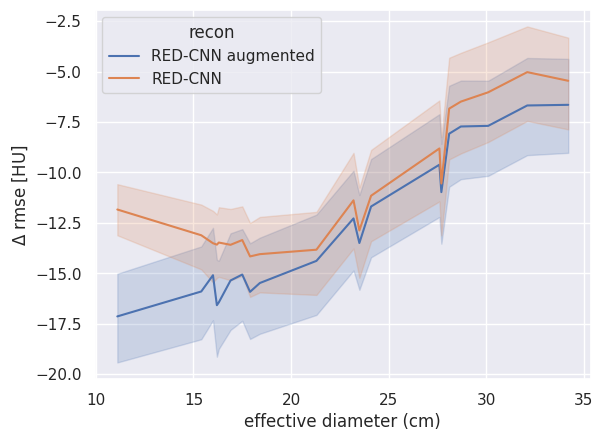

In [217]:
sns.lineplot(data=delta_rmse, x='effective diameter (cm)', y='$\Delta$ rmse [HU]', hue='recon')

<Axes: xlabel='effective diameter (cm)', ylabel='$\\Delta$ rmse [%]'>

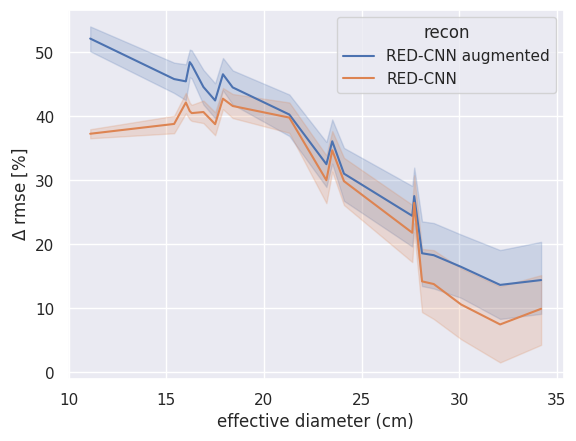

In [218]:
sns.lineplot(data=delta_rmse, x='effective diameter (cm)', y='$\Delta$ rmse [%]', hue='recon')

In [219]:
from pathlib import Path
import numpy as np

infant_dir = Path('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_infant_ref_atn_1/monochromatic/diameter111mm/I0_0075000/fbp_sharp')
adult_dir = Path('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_pt148_atn_1/monochromatic/diameter342mm/I0_0075000/fbp_sharp')

Code #                                                                   151
Name                                                            female pt151
age (year)                                                              66.0
gender                                                                     F
weight (kg)                                                             66.4
height (cm)                                                            162.0
BMI                                                                25.301021
weight percentile                                                       48.8
ethnicity                                                              white
effective diameter (cm)                                                 28.1
Dose [%]                                                                  85
recon                                                                    fbp
file                       female_pt151/diameter281mm/dose_085/fbp/female...

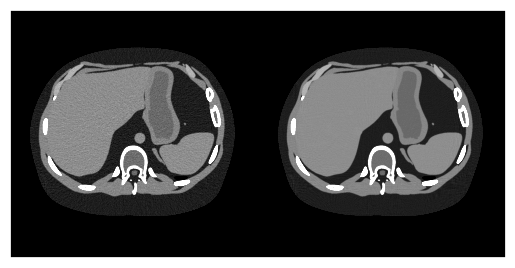

In [220]:

img = load_img(base_dir / patient.file) - 1000
gt = load_img(base_dir / Path(patient.file).parents[2] / 'noise_free.mhd') - 1000
print(patient)
ctshow(np.concatenate([img[1], gt], axis=1))

In [221]:
infant_imfile = list(infant_dir.rglob('*.raw'))[0]
adult_imfile = list(adult_dir.rglob('*.raw'))[0]

In [222]:
infant_img = np.fromfile(infant_imfile, dtype='int16').reshape(1, 512,512) - 1000
infant_gt = np.fromfile('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_infant_ref_atn_1/monochromatic/diameter111mm/noise_free.raw', dtype='int16').reshape(1, 512,512) - 1000
adult_img = np.fromfile(adult_imfile, dtype='int16').reshape(1, 512,512) - 1000
adult_gt = np.fromfile('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_pt148_atn_1/monochromatic/diameter342mm/noise_free.raw', dtype='int16').reshape(1, 512,512) - 1000

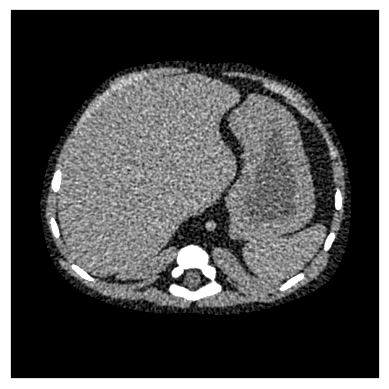

In [223]:
ctshow(infant_img[0])

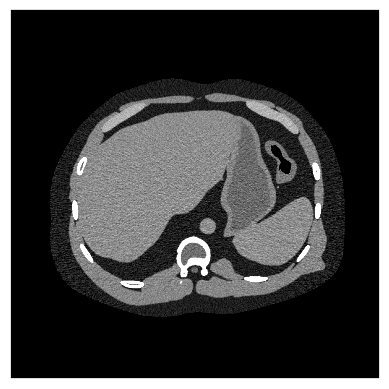

In [224]:
ctshow(adult_img[0])

In [225]:
infant_base_denoised = base_denoising_model.predict(infant_img, batch_size=1)
infant_aug_denoised = aug_denoising_model.predict(infant_img, batch_size=1)

adult_base_denoised = base_denoising_model.predict(adult_img, batch_size=1)
adult_aug_denoised = aug_denoising_model.predict(adult_img, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


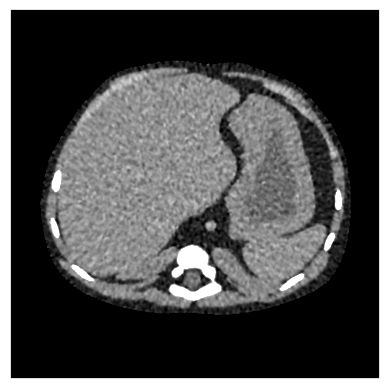

In [226]:
ctshow(infant_base_denoised[0])

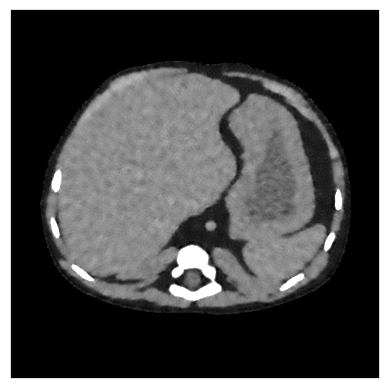

In [227]:
ctshow(infant_aug_denoised[0])

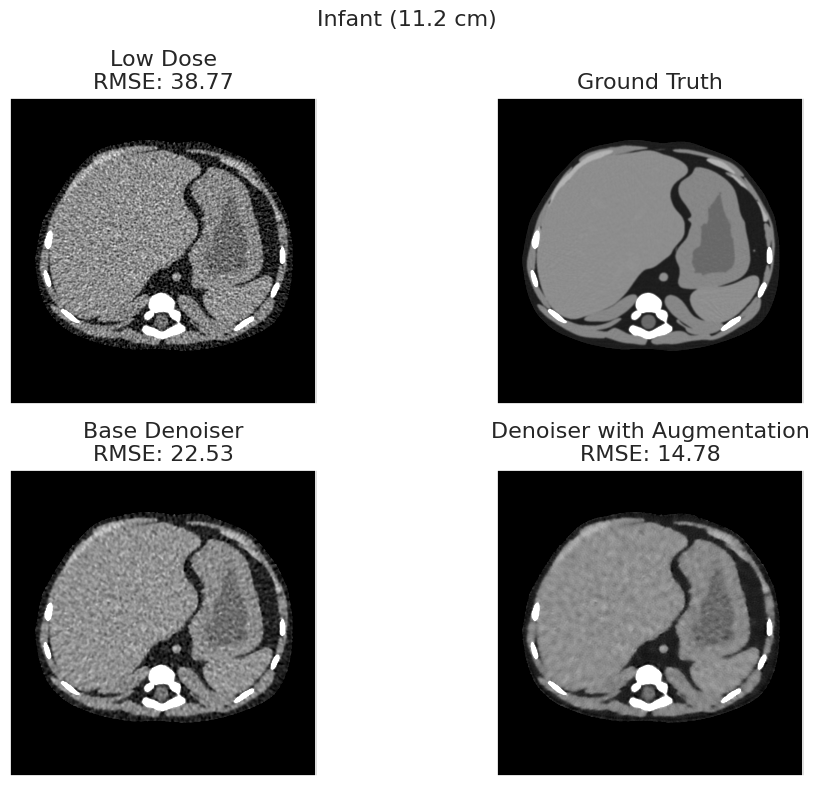

In [228]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Infant (11.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(infant_img, infant_gt):2.2f}', fontsize=16)
ctshow(infant_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(infant_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(infant_base_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(infant_aug_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_aug_denoised.squeeze())

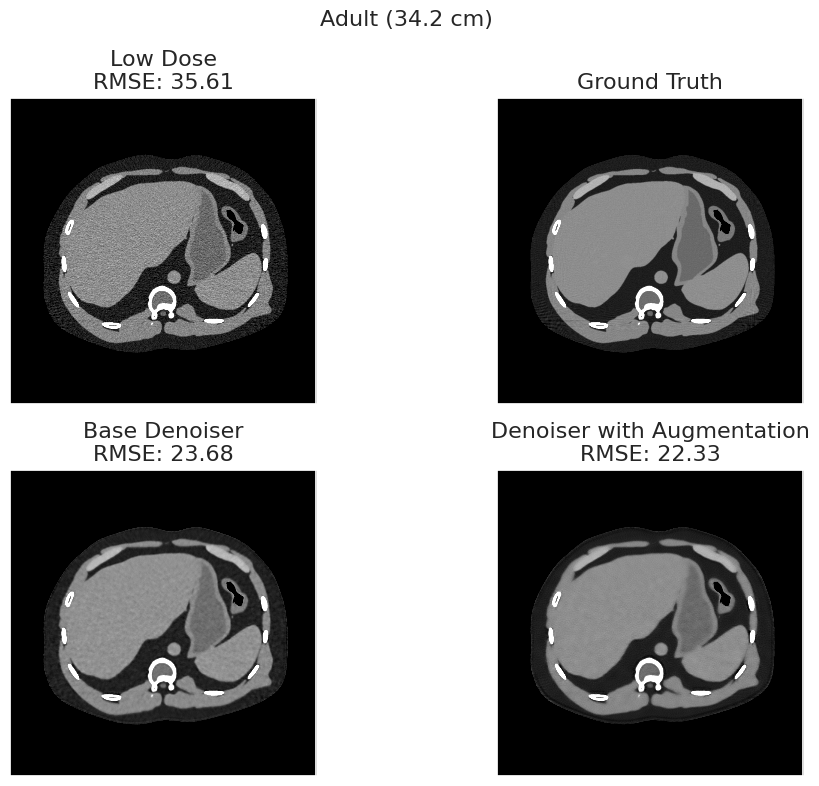

In [229]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Adult (34.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(adult_img, adult_gt):2.2f}', fontsize=16)
ctshow(adult_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(adult_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(adult_base_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(adult_aug_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_aug_denoised.squeeze())

Make these images for a range of sizes infant to adult and [plot RMSE as a function of size](https://github.com/bnel1201/Ped-ETK/blob/main/evaluation/iq_phantom_validation.py) (similar to in [Nelson et al 2022](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901)), I want to see another line with augmentation improve that trend

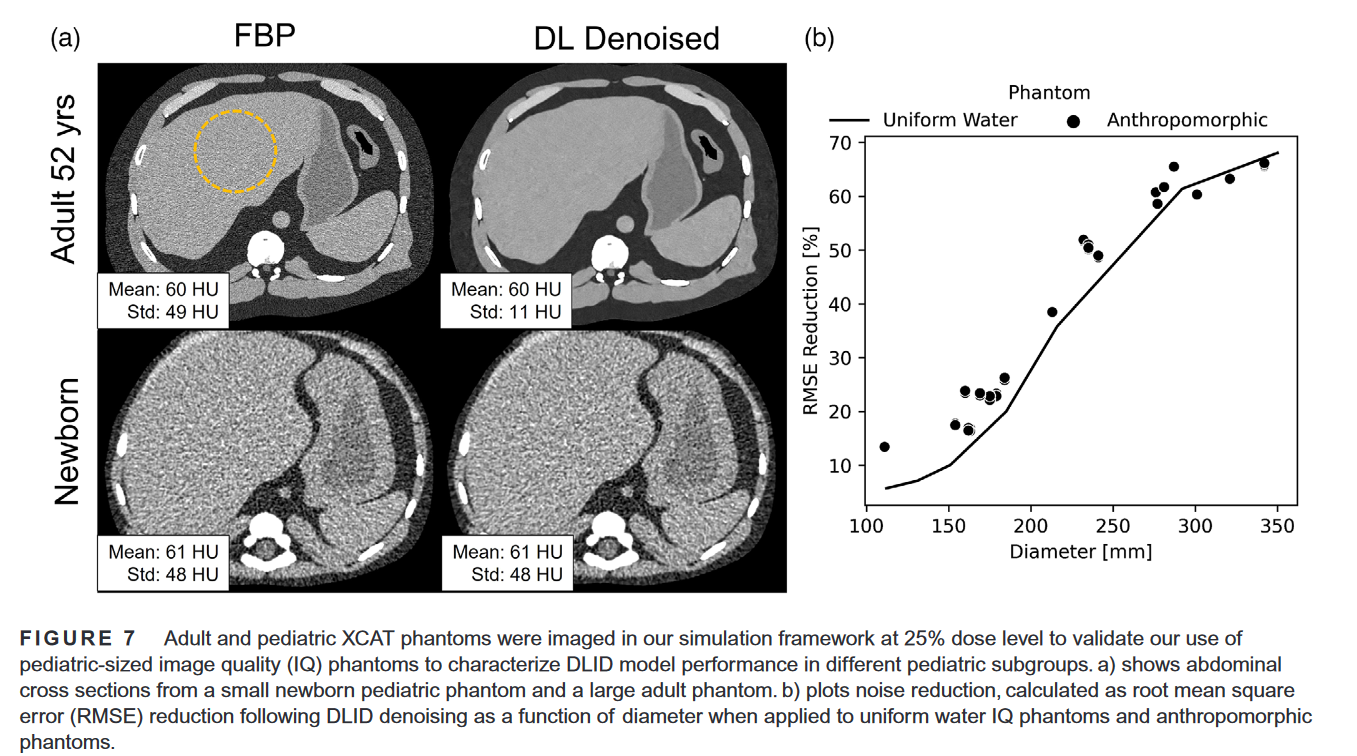